## Setup

In [101]:
import os

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import urllib.request as urlreq

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, Subset, DataLoader, random_split
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

## Loading Dataset

In [102]:
train_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                         transforms.RandomRotation(35),
                         transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])
val_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])

train_data = datasets.ImageFolder('new_images/images/train', transform=train_transforms)
test_data = datasets.ImageFolder('new_images/images/test', transform=test_transforms)
val_data = datasets.ImageFolder('new_images/images/validation',transform=val_transforms)

batch = 128

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch, shuffle=True)
valloader =  torch.utils.data.DataLoader(val_data,batch_size=batch, shuffle=True)

In [9]:
if torch.cuda.is_available():
    print("Using the GPU. You are good to go!")
    device = 'cuda'
else:
    print("Using the CPU. Overall speed may be slowed down")
    device = 'cpu'


Using the GPU. You are good to go!


In [10]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining Layers
        
        self.Layer1 = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
        )
       
        self.Layer2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
        )

       
        self.Layer3 = nn.MaxPool2d(6)

        self.fcLayer = nn.Linear(8192,6) 

        
  
    def forward(self, x):

        x = x.to(device)
       
        x = self.Layer1(x)
        
        x = self.Layer2(x)
        x = self.Layer2(x)
        x = self.Layer2(x)

        x = self.Layer3(x)

        x = x.view(x.shape[0],-1)
       
        x = self.fcLayer(x)
       
        return x 


model = Network().to(device)
criterion = nn.CrossEntropyLoss() # Specify the loss layer
print('Your network:')
print(summary(model, (1,48,48), device=device)) # visualize your model


# Set up optimization hyperparameters
learning_rate = 0.001
weight_decay = 1e-5
num_epoch = 50  # TODO: Choose an appropriate number of training epochs
optimizer = optim.Adam(model.parameters(), lr=learning_rate,
                       weight_decay=weight_decay) # Try different optimizers


Your network:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 48, 48]           1,280
       BatchNorm2d-2          [-1, 128, 48, 48]             256
              ReLU-3          [-1, 128, 48, 48]               0
           Dropout-4          [-1, 128, 48, 48]               0
            Conv2d-5          [-1, 128, 48, 48]         147,584
       BatchNorm2d-6          [-1, 128, 48, 48]             256
              ReLU-7          [-1, 128, 48, 48]               0
           Dropout-8          [-1, 128, 48, 48]               0
            Conv2d-9          [-1, 128, 48, 48]         147,584
      BatchNorm2d-10          [-1, 128, 48, 48]             256
             ReLU-11          [-1, 128, 48, 48]               0
          Dropout-12          [-1, 128, 48, 48]               0
           Conv2d-13          [-1, 128, 48, 48]         147,584
      BatchNorm2d-14     

In [96]:
%%time
def train(model, trainloader, valloader, num_epoch=10): 
    print("Start training...")
    trn_loss_hist = []
    trn_acc_hist = []
    val_acc_hist = []
    model.train()
    for i in range(num_epoch):
        running_loss = []
        print('-----------------Epoch = %d-----------------' % (i+1))
        for batch, label in tqdm(trainloader):
            batch = batch.to(device)
            label = label.to(device)
            optimizer.zero_grad()  
            pred = model(batch)
            loss = criterion(pred, label) 
            running_loss.append(loss.item())
            loss.backward()
            optimizer.step()
        print("\n Epoch {} loss:{}".format(i+1, np.mean(running_loss)))

        trn_loss_hist.append(np.mean(running_loss))
        trn_acc_hist.append(evaluate(model, trainloader))
        print("\n Evaluate on validation set...")
        val_acc_hist.append(evaluate(model, valloader))
    print("Done!")
    return trn_loss_hist, trn_acc_hist, val_acc_hist


def evaluate(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch, label in tqdm(loader):
            batch = batch.to(device)
            label = label.to(device)
            pred = model(batch)
            correct += (torch.argmax(pred, dim=1) == label).sum().item()
        acc = correct/len(loader.dataset)
        print("\n Evaluation accuracy: {}".format(acc))
        return acc


trn_loss_hist, trn_acc_hist, val_acc_hist = train(model, trainloader,
                                                  valloader, num_epoch)

print("\n Evaluate on test set")
evaluate(model, testloader)

Start training...
-----------------Epoch = 1-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.78it/s]



 Epoch 1 loss:3.951384606704213


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.98it/s]



 Evaluation accuracy: 0.1973576403113478

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.45it/s]



 Evaluation accuracy: 0.18794071089365377
-----------------Epoch = 2-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.72it/s]



 Epoch 2 loss:1.7878392381605759


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.95it/s]



 Evaluation accuracy: 0.19131503482179435

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.47it/s]



 Evaluation accuracy: 0.17498920708015542
-----------------Epoch = 3-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.75it/s]



 Epoch 3 loss:1.7824158247779398


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.97it/s]



 Evaluation accuracy: 0.20145432199918067

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.48it/s]



 Evaluation accuracy: 0.18016980860555476
-----------------Epoch = 4-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.72it/s]



 Epoch 4 loss:1.759549172875149


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00, 10.12it/s]



 Evaluation accuracy: 0.23151372388365424

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.42it/s]



 Evaluation accuracy: 0.22621959994243776
-----------------Epoch = 5-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.73it/s]



 Epoch 5 loss:1.7363657180000753


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.97it/s]



 Evaluation accuracy: 0.25594018844735766

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.57it/s]



 Evaluation accuracy: 0.2898258742265074
-----------------Epoch = 6-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.65it/s]



 Epoch 6 loss:1.7132372840557224


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.95it/s]



 Evaluation accuracy: 0.27145637034002457

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.37it/s]



 Evaluation accuracy: 0.2788890487839977
-----------------Epoch = 7-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.71it/s]



 Epoch 7 loss:1.6899812486436632


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.96it/s]



 Evaluation accuracy: 0.28471937730438346

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.45it/s]



 Evaluation accuracy: 0.3200460497913369
-----------------Epoch = 8-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.59it/s]



 Epoch 8 loss:1.6778225524752748


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.87it/s]



 Evaluation accuracy: 0.29828963539532977

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.30it/s]



 Evaluation accuracy: 0.3158727874514319
-----------------Epoch = 9-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.73it/s]



 Epoch 9 loss:1.6590306875752467


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.93it/s]



 Evaluation accuracy: 0.2916837361736993

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.30it/s]



 Evaluation accuracy: 0.3174557490286372
-----------------Epoch = 10-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.74it/s]



 Epoch 10 loss:1.648623602842194


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.89it/s]



 Evaluation accuracy: 0.32686399016796397

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.31it/s]



 Evaluation accuracy: 0.34781983019139445
-----------------Epoch = 11-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.70it/s]



 Epoch 11 loss:1.632851708169077


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.28it/s]



 Evaluation accuracy: 0.33628635804997953

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.30it/s]



 Evaluation accuracy: 0.3794790617355015
-----------------Epoch = 12-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.72it/s]



 Epoch 12 loss:1.6209953088386386


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.99it/s]



 Evaluation accuracy: 0.3505223269151987

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.52it/s]



 Evaluation accuracy: 0.38365232407540656
-----------------Epoch = 13-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.72it/s]



 Epoch 13 loss:1.5977872875001695


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.95it/s]



 Evaluation accuracy: 0.36808684965178207

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.46it/s]



 Evaluation accuracy: 0.3996258454453878
-----------------Epoch = 14-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.73it/s]



 Epoch 14 loss:1.5754053919923072


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.95it/s]



 Evaluation accuracy: 0.3764850471118394

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.32it/s]



 Evaluation accuracy: 0.402503957403943
-----------------Epoch = 15-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.70it/s]



 Epoch 15 loss:1.5457344842112921


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00, 10.01it/s]



 Evaluation accuracy: 0.3818107333060221

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.36it/s]



 Evaluation accuracy: 0.4092675205065477
-----------------Epoch = 16-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.71it/s]



 Epoch 16 loss:1.523899436776155


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.93it/s]



 Evaluation accuracy: 0.38570258090946336

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.40it/s]



 Evaluation accuracy: 0.4108504820837531
-----------------Epoch = 17-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.71it/s]



 Epoch 17 loss:1.5082937167360893


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.94it/s]



 Evaluation accuracy: 0.3989143793527243

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.42it/s]



 Evaluation accuracy: 0.4446682975967765
-----------------Epoch = 18-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.69it/s]



 Epoch 18 loss:1.4815043966754589


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.92it/s]



 Evaluation accuracy: 0.41002662843097093

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.53it/s]



 Evaluation accuracy: 0.44107065764858255
-----------------Epoch = 19-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.66it/s]



 Epoch 19 loss:1.469010948355681


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.93it/s]



 Evaluation accuracy: 0.42933224088488325

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.36it/s]



 Evaluation accuracy: 0.4603540077709023
-----------------Epoch = 20-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.74it/s]



 Epoch 20 loss:1.450066089630127


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.93it/s]



 Evaluation accuracy: 0.4327120032773453

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.57it/s]



 Evaluation accuracy: 0.4592027629874802
-----------------Epoch = 21-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.70it/s]



 Epoch 21 loss:1.4299112597322152


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.90it/s]



 Evaluation accuracy: 0.44848422777550184

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.37it/s]



 Evaluation accuracy: 0.4776226795222334
-----------------Epoch = 22-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.68it/s]



 Epoch 22 loss:1.4200882155910817


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.94it/s]



 Evaluation accuracy: 0.44771609995903316

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.36it/s]



 Evaluation accuracy: 0.4710030220175565
-----------------Epoch = 23-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.71it/s]



 Epoch 23 loss:1.407862451341417


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.87it/s]



 Evaluation accuracy: 0.45135190495698485

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.28it/s]



 Evaluation accuracy: 0.4851057706144769
-----------------Epoch = 24-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.39it/s]



 Epoch 24 loss:1.4016438208374322


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.87it/s]



 Evaluation accuracy: 0.4612351495288816

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.35it/s]



 Evaluation accuracy: 0.4875521657792488
-----------------Epoch = 25-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.69it/s]



 Epoch 25 loss:1.3871216680489333


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00, 10.03it/s]



 Evaluation accuracy: 0.4683019254403933

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.33it/s]



 Evaluation accuracy: 0.4888473161605986
-----------------Epoch = 26-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.71it/s]



 Epoch 26 loss:1.3781878722259422


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.96it/s]



 Evaluation accuracy: 0.47777550184350676

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.39it/s]



 Evaluation accuracy: 0.49489135127356454
-----------------Epoch = 27-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.72it/s]



 Epoch 27 loss:1.3661433411579507


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.96it/s]



 Evaluation accuracy: 0.47378123719786974

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.30it/s]



 Evaluation accuracy: 0.4989207080155418
-----------------Epoch = 28-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.70it/s]



 Epoch 28 loss:1.3591019491744196


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.91it/s]



 Evaluation accuracy: 0.47726341663252764

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.37it/s]



 Evaluation accuracy: 0.4983450856238308
-----------------Epoch = 29-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.67it/s]



 Epoch 29 loss:1.3523565787895053


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.91it/s]



 Evaluation accuracy: 0.47101597705858256

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.48it/s]



 Evaluation accuracy: 0.4941718232839257
-----------------Epoch = 30-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.71it/s]



 Epoch 30 loss:1.3414531541026495


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.99it/s]



 Evaluation accuracy: 0.4880172060630889

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.30it/s]



 Evaluation accuracy: 0.5105770614476903
-----------------Epoch = 31-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.58it/s]



 Epoch 31 loss:1.3322739258311154


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.96it/s]



 Evaluation accuracy: 0.4798238426874232

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.33it/s]



 Evaluation accuracy: 0.5061159879119298
-----------------Epoch = 32-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.69it/s]



 Epoch 32 loss:1.3234819875043982


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00, 10.01it/s]



 Evaluation accuracy: 0.49405981155264234

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.43it/s]



 Evaluation accuracy: 0.5123039286228235
-----------------Epoch = 33-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.71it/s]



 Epoch 33 loss:1.3144319244459564


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.97it/s]



 Evaluation accuracy: 0.4889389594428513

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.40it/s]



 Evaluation accuracy: 0.505972082314002
-----------------Epoch = 34-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.71it/s]



 Epoch 34 loss:1.308824278949912


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.88it/s]



 Evaluation accuracy: 0.49651782056534205

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.30it/s]



 Evaluation accuracy: 0.514318606993812
-----------------Epoch = 35-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.71it/s]



 Epoch 35 loss:1.3046870223836962


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.95it/s]



 Evaluation accuracy: 0.5040966816878328

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.32it/s]



 Evaluation accuracy: 0.5189235861275003
-----------------Epoch = 36-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.68it/s]



 Epoch 36 loss:1.302875920058855


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.91it/s]



 Evaluation accuracy: 0.5061450225317493

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.21it/s]



 Evaluation accuracy: 0.5098575334580515
-----------------Epoch = 37-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.71it/s]



 Epoch 37 loss:1.2888094023162244


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.92it/s]



 Evaluation accuracy: 0.5015362556329374

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.49it/s]



 Evaluation accuracy: 0.5036695927471578
-----------------Epoch = 38-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.71it/s]



 Epoch 38 loss:1.2871148804433985


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.97it/s]



 Evaluation accuracy: 0.5081421548545678

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.33it/s]



 Evaluation accuracy: 0.5123039286228235
-----------------Epoch = 39-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.69it/s]



 Epoch 39 loss:1.2785890788034675


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.96it/s]



 Evaluation accuracy: 0.5111122490782466

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 11.96it/s]



 Evaluation accuracy: 0.5182040581378615
-----------------Epoch = 40-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.64it/s]



 Epoch 40 loss:1.2742979838178048


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.94it/s]



 Evaluation accuracy: 0.5047111839410078

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.33it/s]



 Evaluation accuracy: 0.5146064181896676
-----------------Epoch = 41-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.26it/s]



 Epoch 41 loss:1.2733408578860215


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.85it/s]



 Evaluation accuracy: 0.5181278164686604

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.48it/s]



 Evaluation accuracy: 0.528709166786588
-----------------Epoch = 42-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.70it/s]



 Epoch 42 loss:1.2583013321059981


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.90it/s]



 Evaluation accuracy: 0.5148504711183941

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.31it/s]



 Evaluation accuracy: 0.5281335443948769
-----------------Epoch = 43-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.67it/s]



 Epoch 43 loss:1.259747442077188


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.95it/s]



 Evaluation accuracy: 0.5231974600573536

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.24it/s]



 Evaluation accuracy: 0.5207943589005612
-----------------Epoch = 44-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.70it/s]



 Epoch 44 loss:1.2511490863912247


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.92it/s]



 Evaluation accuracy: 0.5182814420319541

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.45it/s]



 Evaluation accuracy: 0.5253993380342495
-----------------Epoch = 45-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.70it/s]



 Epoch 45 loss:1.2372067387587105


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.88it/s]



 Evaluation accuracy: 0.5265260139287178

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.38it/s]



 Evaluation accuracy: 0.5205065477047057
-----------------Epoch = 46-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.69it/s]



 Epoch 46 loss:1.2450202306111653


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.30it/s]



 Evaluation accuracy: 0.5292400655469071

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.38it/s]



 Evaluation accuracy: 0.5307238451575766
-----------------Epoch = 47-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.69it/s]



 Epoch 47 loss:1.2344069878260295


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.86it/s]



 Evaluation accuracy: 0.5375870544858664

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.38it/s]



 Evaluation accuracy: 0.5363361634767593
-----------------Epoch = 48-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.69it/s]



 Epoch 48 loss:1.230616232148962


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.95it/s]



 Evaluation accuracy: 0.5388672675133143

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.49it/s]



 Evaluation accuracy: 0.5297165059720823
-----------------Epoch = 49-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.71it/s]



 Epoch 49 loss:1.2261145075941398


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.89it/s]



 Evaluation accuracy: 0.5448586644817698

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.28it/s]



 Evaluation accuracy: 0.5325946179306374
-----------------Epoch = 50-----------------


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:14<00:00, 10.66it/s]



 Epoch 50 loss:1.220048764951868


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:15<00:00,  9.88it/s]



 Evaluation accuracy: 0.5334903727980336

 Evaluate on validation set...


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:04<00:00, 12.46it/s]



 Evaluation accuracy: 0.5343214851057706
Done!

 Evaluate on test set


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:04<00:00, 12.50it/s]


 Evaluation accuracy: 0.5346018322762509
CPU times: total: 28min 34s
Wall time: 28min 33s


0.5346018322762509

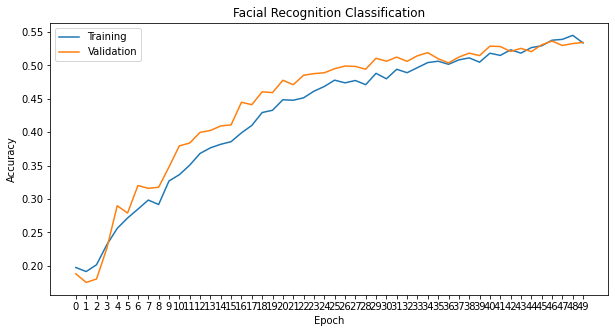

In [97]:
# visualize the training / validation accuracies
x = np.arange(num_epoch)
# train/val accuracies for MiniVGG
plt.figure()
plt.plot(x, trn_acc_hist)
plt.plot(x, val_acc_hist)
plt.legend(['Training', 'Validation'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Facial Recognition Classification')
plt.gcf().set_size_inches(10, 5)
plt.savefig('part1.png', dpi=300)
plt.show()

In [146]:
from numpy.random import randint

raw_test_transforms = transforms.Compose([transforms.ToTensor()])
raw_test_data = datasets.ImageFolder('images/test', transform=raw_test_transforms)

num_photos_to_test = 1
random_indices = randint(0, len(test_data), num_photos_to_test)

sampler = SubsetRandomSampler(random_indices)
sample_test_loader = torch.utils.data.DataLoader(test_data, sampler=sampler, batch_size=num_photos_to_test)
raw_sample_test_loader = torch.utils.data.DataLoader(raw_test_data, sampler=sampler, batch_size=num_photos_to_test)

dataiter = iter(sample_test_loader)
test_images, labels = dataiter.next()

dataiter = iter(raw_sample_test_loader)
raw_test_images, labels = dataiter.next()


to_pil = transforms.ToPILImage()

image = to_pil(test_images[i])
raw_image = to_pil(raw_test_images[i])
image_tensor = test_transforms(image).float()
image_tensor = image_tensor.unsqueeze_(0)
output = model(image_tensor.to(device))
prediction = output.data.cpu().numpy().argmax()

classes = trainloader.dataset.classes
res = int(labels[0]) == index





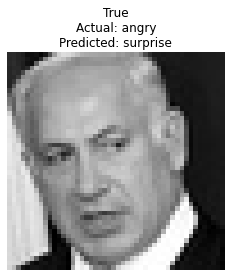

In [147]:
plt.imshow(raw_image)
plt.title(str(res) + "\nActual: " + classes[int(labels[0])] + "\nPredicted: "+str(classes[prediction]))
plt.axis('off')
plt.show()

plt.show()

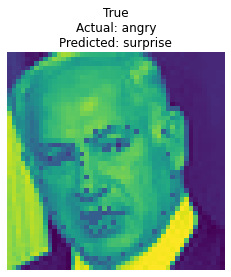

In [148]:
plt.imshow(image)
plt.title(str(res) + "\nActual: " + classes[int(labels[0])] + "\nPredicted: "+str(classes[prediction]))
plt.axis('off')
plt.show()

plt.show()